# Skin cancer detection with transfer learning

### Downloading the dataset

In [1]:
! mkdir -p ./dataset
! curl -L -o ./dataset/archive.zip https://www.kaggle.com/api/v1/datasets/download/fanconic/skin-cancer-malignant-vs-benign
! unzip -o ./dataset/archive.zip -d ./dataset
! rm ./dataset/archive.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  324M  100  324M    0     0  13.4M      0  0:00:24  0:00:24 --:--:-- 13.5M
Archive:  ./dataset/archive.zip
  inflating: ./dataset/data/test/benign/1.jpg  
  inflating: ./dataset/data/test/benign/10.jpg  
  inflating: ./dataset/data/test/benign/1003.jpg  
  inflating: ./dataset/data/test/benign/1006.jpg  
  inflating: ./dataset/data/test/benign/1013.jpg  
  inflating: ./dataset/data/test/benign/1018.jpg  
  inflating: ./dataset/data/test/benign/1019.jpg  
  inflating: ./dataset/data/test/benign/1023.jpg  
  inflating: ./dataset/data/test/benign/1025.jpg  
  inflating: ./dataset/data/test/benign/1029.jpg  
  inflating: ./dataset/data/test/benign/1033.jpg  
  inflating: ./dataset/data/test/benign/1034.jpg  
  inflating: ./dataset/data/test/benign/1042.

### Installing the required libraries

In [2]:
%pip install torch torchvision matplotlib numpy pandas scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Importing the libraries

In [3]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import random
import torchvision.transforms.functional as TF
import torchvision.models as models
import torch.optim as optim


### Reading the dataset

In [ ]:
# Read the dataset as tensors and create the PyTorch datasets
# The images are in 4 folders:
# dataset/train/benign, dataset/train/malignant, dataset/test/benign, dataset/test/malignant
# where benign and malignant are the two classes of skin cancer.

class SkinCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.classes = []
        # Iterate over the directories in the root directory
        for i, d in enumerate(os.listdir(root_dir)):
            self.classes.append(d)
            # Iterate over the files in each directory
            for f in os.listdir(os.path.join(root_dir, d)):
                self.images.append(os.path.join(root_dir, d, f))
                self.labels.append(i)
        
    def __len__(self):
        # Return the total number of images
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load the image and its corresponding label
        image = Image.open(self.images[idx])
        label = self.labels[idx]
        # Apply the transformations if any
        if self.transform:
            image = self.transform(image)
        return image, label
    
# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create the training and testing datasets
train_dataset = SkinCancerDataset('./dataset/train', transform=transform)
test_dataset = SkinCancerDataset('./dataset/test', transform=transform)

# Create the data loaders for training and testing datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print('Train dataset size:', len(train_dataset))
print('Train data samples:', train_dataset[0][0].shape)
print('Test dataset size:', len(test_dataset))
print('Test data samples:', test_dataset[0][0].shape)


Train dataset size: 2637
Train data samples: torch.Size([3, 224, 224])
Test dataset size: 660
Test data samples: torch.Size([3, 224, 224])


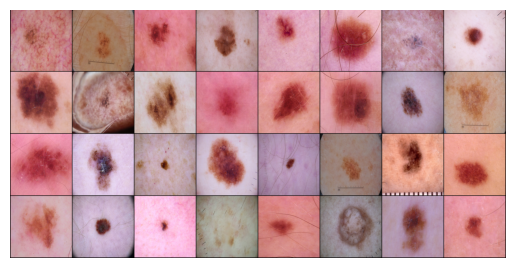

malignant malignant benign malignant benign benign benign benign benign benign benign benign benign benign benign malignant benign malignant benign malignant benign malignant malignant benign benign malignant benign malignant benign benign malignant benign


In [5]:
# Function to display an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join('%5s' % train_dataset.classes[labels[j]] for j in range(32)))


### Data Augmentation

In [6]:
# Define a class for random rotation
class RandomRotation:
    def __init__(self, degrees):
        self.degrees = degrees
        
    def __call__(self, x):
        angle = random.uniform(-self.degrees, self.degrees)
        return TF.rotate(x, angle)

# Define a class for random horizontal flip
class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, x):
        if random.random() < self.p:
            return TF.hflip(x)
        return x

# Define a class for random vertical flip
class RandomVerticalFlip:
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, x):
        if random.random() < self.p:
            return TF.vflip(x)
        return x

# Define a class for random resized crop
class RandomResizedCrop:
    def __init__(self, size, scale=(0.5, 1.0), ratio=(0.75, 1.3333333333333333)):
        self.size = size
        self.scale = scale
        self.ratio = ratio
        
    def __call__(self, x):
        i, j, h, w = transforms.RandomResizedCrop.get_params(x, scale=self.scale, ratio=self.ratio)
        return TF.resized_crop(x, i, j, h, w, self.size)

# Define the augmentation transform
transform_augmented = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToPILImage(),
    RandomRotation(10),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomResizedCrop((224, 224)),
    transforms.ToTensor()
])

# Create a new dataset with augmented samples
class AugmentedSkinCancerDataset(Dataset):
    def __init__(self, original_dataset, transform=None, augment_factor=4):
        self.original_dataset = original_dataset
        self.transform = transform
        self.augment_factor = augment_factor
        
    def __len__(self):
        return len(self.original_dataset) * self.augment_factor
    
    def __getitem__(self, idx):
        original_idx = idx % len(self.original_dataset)
        image, label = self.original_dataset[original_idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Create the augmented dataset and dataloader
train_dataset_augmented = AugmentedSkinCancerDataset(train_dataset, transform=transform_augmented)

print('Augmented train dataset size:', len(train_dataset_augmented))



Augmented train dataset size: 10548


### Splitting the dataset

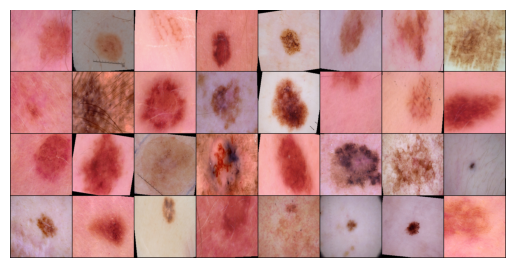

Train dataset augmented size: 8438
Train data augmented samples: torch.Size([3, 224, 224])
Validation dataset augmented size: 2110
Validation data augmented samples: torch.Size([3, 224, 224])


In [7]:
# Split the augmented dataset into a training and validation set
train_dataset_augmented, val_dataset_augmented = torch.utils.data.random_split(
    train_dataset_augmented, 
    [int(0.8 * len(train_dataset_augmented)), len(train_dataset_augmented) - int(0.8 * len(train_dataset_augmented))]
)

# Create data loaders for the augmented training and validation datasets
train_loader_augmented = torch.utils.data.DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)
val_loader_augmented = torch.utils.data.DataLoader(val_dataset_augmented, batch_size=32, shuffle=False)

# Get a batch of augmented training data
dataiter = iter(train_loader_augmented)
images, labels = next(dataiter)

# Show augmented images
imshow(torchvision.utils.make_grid(images))

# Print dataset sizes and sample shapes
print('Train dataset augmented size:', len(train_dataset_augmented))
print('Train data augmented samples:', train_dataset_augmented[0][0].shape)
print('Validation dataset augmented size:', len(val_dataset_augmented))
print('Validation data augmented samples:', val_dataset_augmented[0][0].shape)

### Getting pretrained model

In [8]:
model = models.vgg16(pretrained=True)
"""
Loads a pre-trained VGG16 model.

The VGG16 model is a convolutional neural network model that is pre-trained on the ImageNet dataset. 
This function initializes the model with pre-trained weights and prints the architecture of the classifier part of the model.

Imports:
    models (torchvision.models): A module containing various pre-trained models.

Usage:

Returns:
    None
"""
print(model.classifier)

/home/vscode/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vscode/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


### Modifying the classifier layer

In [9]:
import torch.nn as nn

# Modify the classifier part of the VGG16 model
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),  # First fully connected layer
    nn.ReLU(inplace=True),   # ReLU activation
    nn.Dropout(0.5),         # Dropout layer
    nn.Linear(4096, 4096),   # Second fully connected layer
    nn.ReLU(inplace=True),   # ReLU activation
    nn.Dropout(0.5),         # Dropout layer
    nn.Linear(4096, 2)       # Output layer with 2 classes
)

# Print the modified classifier
print(model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


### Training the model

In [ ]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Initialize lists to store training losses and accuracies
train_losses = []
train_accuracies = []

# Define the training function
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=5):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        print('Epoch', epoch + 1)
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 10 == 9:  # Print every 10 mini-batches
                iter_loss = running_loss / 10
                train_losses.append(iter_loss)
                running_loss = 0.0
                _, predicted = torch.max(outputs, 1)
                correct = (predicted == labels).sum().item()
                accuracy = correct / labels.size(0)
                train_accuracies.append(accuracy)
                if i % 100 == 99:  # Print every 100 mini-batches
                    print('Iteration', i + 1, 'loss', iter_loss, 'accuracy', accuracy)
        # Validation step
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        val_loss /= len(val_loader)
        val_accuracy = correct / total

        print('Epoch', epoch + 1, 'finished')
        print('Validation loss:', val_loss, 'accuracy:', val_accuracy)
        model.train()  # Set the model back to training mode

# Train the model for x epochs
train(model, train_loader_augmented, val_loader_augmented, criterion, optimizer, device, epochs=5)


Epoch 1
Iteration 100 loss 0.4785053670406342 accuracy 0.78125
Iteration 200 loss 0.3747273236513138 accuracy 0.8125
Epoch 1 finished
Validation loss: 0.3344055872523423 accuracy: 0.8464454976303317
Epoch 2
Iteration 100 loss 0.35457650721073153 accuracy 0.8125
Iteration 200 loss 0.3195867672562599 accuracy 0.8125
Epoch 2 finished
Validation loss: 0.29805411669341003 accuracy: 0.8568720379146919
Epoch 3
Iteration 100 loss 0.2524770855903625 accuracy 0.90625
Iteration 200 loss 0.3182057484984398 accuracy 0.8125
Epoch 3 finished
Validation loss: 0.2976756301341635 accuracy: 0.862085308056872
Epoch 4
Iteration 100 loss 0.24109092801809312 accuracy 0.9375
Iteration 200 loss 0.2205989859998226 accuracy 0.875
Epoch 4 finished
Validation loss: 0.2191461068436955 accuracy: 0.9033175355450237
Epoch 5
Iteration 100 loss 0.22011136636137962 accuracy 0.875
Iteration 200 loss 0.22743440717458724 accuracy 0.875
Epoch 5 finished
Validation loss: 0.26673601217793697 accuracy: 0.8796208530805687


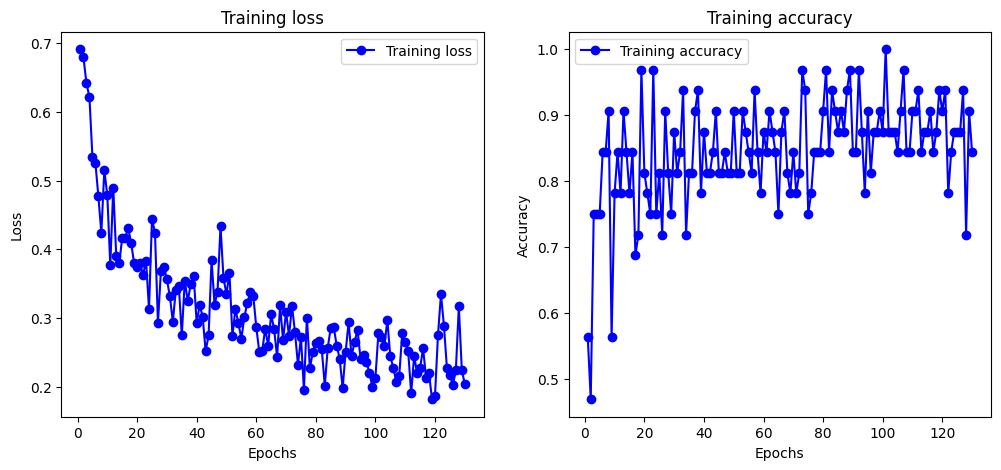

In [11]:


# Function to plot training metrics
def plot_metrics(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
    plt.title('Training accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

# Call the function to plot the metrics
plot_metrics(train_losses, train_accuracies)


### Evaluating the model

In [12]:
def evaluate(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    loss = 0
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()  # Accumulate the loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # Count correct predictions
    return loss / total, correct / total  # Return average loss and accuracy

# Evaluate the model on the training, validation, and test datasets
train_loss, train_accuracy = evaluate(model, train_loader, device)
val_loss, val_accuracy = evaluate(model, val_loader_augmented, device)
test_loss, test_accuracy = evaluate(model, test_loader, device)

# Print the evaluation results
print('Train loss:', train_loss)
print('Train accuracy:', train_accuracy)
print('Validation loss:', val_loss)
print('Validation accuracy:', val_accuracy)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Train loss: 0.008081126035638592
Train accuracy: 0.8839590443686007
Validation loss: 0.008298914060349712
Validation accuracy: 0.8834123222748815
Test loss: 0.009701880528309354
Test accuracy: 0.8560606060606061
